Threshold-based Confusion Matrix Analysis (Ratio = 0.9)

Detected 10 folds in the output directory
Loading original data from Cancer2025exam.csv...
Loaded 1715 samples from original dataset

--- Processing FS_PCA_NN ---
FS_PCA_NN: Loaded 1715 samples from 1715 folds
Samples with confidence > 0.9: 1522/1715 (88.7%)

--- Processing RF ---
RF: Loaded 1715 samples from 1715 folds
Samples with confidence > 0.9: 8/1715 (0.5%)

--- Processing FS_PCA_KNN ---
FS_PCA_KNN: Loaded 1715 samples from 1715 folds
Samples with confidence > 0.9: 851/1715 (49.6%)

--- Processing FS_PCA_QDA ---
FS_PCA_QDA: Loaded 1715 samples from 1715 folds
Samples with confidence > 0.9: 1627/1715 (94.9%)

--- Processing FS_PCA_LR ---
FS_PCA_LR: Loaded 1715 samples from 1715 folds
Samples with confidence > 0.9: 322/1715 (18.8%)

--- Generating Confusion Matrices ---


/var/folders/d1/zy6_8ldn1lqfx509grbjvys80000gn/T/ipykernel_80038/2319466780.py:138: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


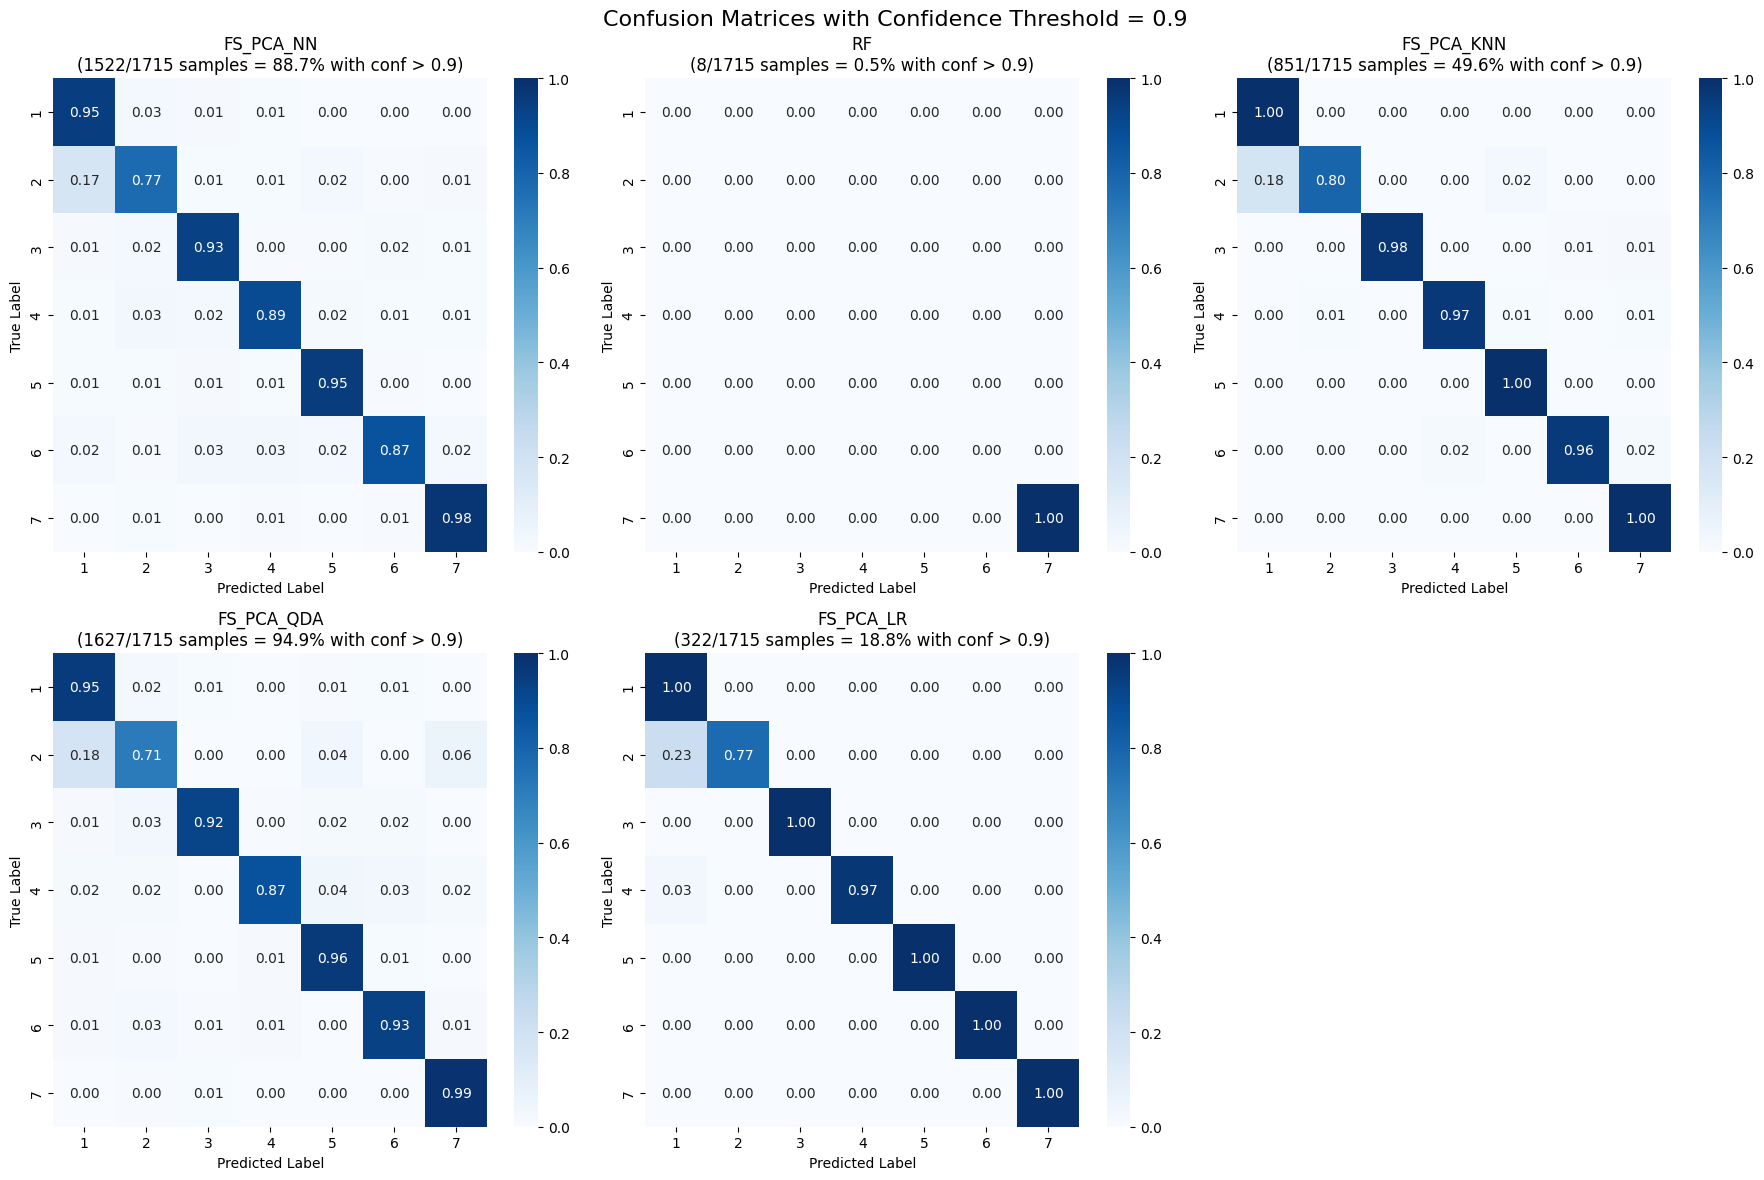


SUMMARY STATISTICS
Confidence threshold: 0.9

Model coverage (% of samples with high confidence):
  FS_PCA_NN: 88.7% (1522/1715 samples)
  RF: 0.5% (8/1715 samples)
  FS_PCA_KNN: 49.6% (851/1715 samples)
  FS_PCA_QDA: 94.9% (1627/1715 samples)
  FS_PCA_LR: 18.8% (322/1715 samples)



In [9]:
#!/usr/bin/env python3
"""
Threshold-based Confusion Matrix Analysis
Creates confusion matrices for models considering only predictions with confidence above a threshold
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix

# Configuration
DATA_PATH = 'Cancer2025exam.csv'  # Original data file
OUTPUT_ROOT = 'output'
PROBABILITIES_DIR = os.path.join(OUTPUT_ROOT, 'probabilities')
INDICES_DIR = os.path.join(OUTPUT_ROOT, 'indices')

# Models to analyze (excluding SVM)
MODEL_SET = ['FS_PCA_NN', 'RF', 'FS_PCA_KNN', 'FS_PCA_QDA', 'FS_PCA_LR']

# Threshold ratio
RATIO = 0.9  # Only consider predictions with max probability > 0.9
JUDGE = 'max'

def detect_n_folds():
    """Detect the actual number of folds from available files"""
    if not os.path.exists(PROBABILITIES_DIR):
        print(f"Warning: Probabilities directory '{PROBABILITIES_DIR}' not found!")
        return 5
    
    max_fold = 0
    for model in MODEL_SET:
        fold = 1
        while os.path.exists(os.path.join(PROBABILITIES_DIR, f"pred_dist_{model}_{fold}.npy")):
            max_fold = max(max_fold, fold)
            fold += 1
    return max_fold if max_fold > 0 else 5

def load_original_data():
    """Load the original dataset to get true labels"""
    print(f"Loading original data from {DATA_PATH}...")
    df = pd.read_csv(DATA_PATH)
    # Labels are in the first column, sample IDs are row indices
    y_all = df.iloc[:, 0].values
    return y_all

def merge_predictions_and_labels(model_name, n_folds, y_all):
    """
    Merge predictions from all folds and get corresponding true labels
    """
    all_predictions = []
    all_sample_ids = []
    all_true_labels = []
    
    for fold_idx in range(1, n_folds + 1):
        # Load prediction probabilities
        prob_filename = f"pred_dist_{model_name}_{fold_idx}.npy"
        prob_path = os.path.join(PROBABILITIES_DIR, prob_filename)
        
        if not os.path.exists(prob_path):
            print(f"Warning: {prob_filename} not found, skipping fold {fold_idx}")
            continue
        
        # Load test sample indices for this fold
        indices_filename = f"test_index_{fold_idx}.npy"
        indices_path = os.path.join(INDICES_DIR, indices_filename)
        
        if not os.path.exists(indices_path):
            print(f"Warning: {indices_filename} not found, skipping fold {fold_idx}")
            continue
        
        # Load data
        prob_data = np.load(prob_path)  # Shape: (n_samples, 1+n_classes)
        test_indices = np.load(indices_path)  # Sample IDs for this fold
        
        # Extract sample IDs and probabilities
        sample_ids_fold = prob_data[:, 0].astype(int)
        probabilities = prob_data[:, 1:]
        
        # Get true labels using sample IDs
        true_labels_fold = y_all[sample_ids_fold]
        
        # Store results
        all_predictions.append(probabilities)
        all_sample_ids.append(sample_ids_fold)
        all_true_labels.append(true_labels_fold)
    
    # Concatenate all folds
    if all_predictions:
        all_predictions = np.vstack(all_predictions)
        all_sample_ids = np.concatenate(all_sample_ids)
        all_true_labels = np.concatenate(all_true_labels)
        
        print(f"{model_name}: Loaded {len(all_sample_ids)} samples from {len(all_predictions)} folds")
        return all_predictions, all_true_labels, all_sample_ids
    else:
        return None, None, None

def create_threshold_confusion_matrix(probabilities, true_labels, threshold=0.9):
    """
    Create confusion matrix considering only predictions with max probability > threshold
    """
    # Get predicted classes and max probabilities
    predicted_classes = np.argmax(probabilities, axis=1) + 1
    max_probabilities = np.max(probabilities, axis=1)
    
    # Filter by threshold
    if JUDGE == 'max':
        mask = max_probabilities > threshold
    elif JUDGE == 'min':
        mask = max_probabilities < threshold
    filtered_true = true_labels[mask]
    filtered_pred = predicted_classes[mask]
    
    # Calculate confusion matrix
    unique_labels = np.sort(np.unique(true_labels))
    cm = confusion_matrix(filtered_true, filtered_pred, labels=unique_labels)
    
    n_filtered = np.sum(mask)
    n_total = len(true_labels)
    
    return cm, n_filtered, n_total, unique_labels

def plot_confusion_matrices(results, ratio):
    """
    Plot all confusion matrices in a grid
    """
    n_models = len(results)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (model_name, (cm, n_filtered, n_total, labels)) in enumerate(results.items()):
        ax = axes[idx]
        
        # Normalize confusion matrix by row (true label)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero
        
        # Create heatmap
        sns.heatmap(cm_normalized, 
                    annot=True, 
                    fmt='.2f', 
                    cmap='Blues',
                    xticklabels=labels, 
                    yticklabels=labels,
                    cbar=True,
                    vmin=0, 
                    vmax=1,
                    ax=ax)
        
        # Add title with statistics
        percentage = (n_filtered / n_total) * 100 if n_total > 0 else 0
        ax.set_title(f'{model_name}\n({n_filtered}/{n_total} samples = {percentage:.1f}% with conf > {ratio})')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
    
    # Remove extra subplot
    if n_models < 6:
        fig.delaxes(axes[5])
    
    plt.suptitle(f'Confusion Matrices with Confidence Threshold = {ratio}', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

def main():
    """
    Main analysis function
    """
    print("="*70)
    print(f"Threshold-based Confusion Matrix Analysis (Ratio = {RATIO})")
    print("="*70)
    
    # Detect number of folds
    n_folds = detect_n_folds()
    print(f"\nDetected {n_folds} folds in the output directory")
    
    # Load original data for true labels
    y_all = load_original_data()
    print(f"Loaded {len(y_all)} samples from original dataset")
    
    # Process each model
    results = {}
    
    for model_name in MODEL_SET:
        print(f"\n--- Processing {model_name} ---")
        
        # Merge predictions from all folds
        probabilities, true_labels, sample_ids = merge_predictions_and_labels(model_name, n_folds, y_all)
        
        if probabilities is None:
            print(f"Error: No data found for {model_name}")
            continue
        
        # Create threshold-based confusion matrix
        cm, n_filtered, n_total, labels = create_threshold_confusion_matrix(
            probabilities, true_labels, threshold=RATIO
        )
        
        results[model_name] = (cm, n_filtered, n_total, labels)
        
        # Print statistics
        print(f"Samples with confidence > {RATIO}: {n_filtered}/{n_total} ({(n_filtered/n_total)*100:.1f}%)")
    
    # Plot all confusion matrices
    if results:
        print(f"\n--- Generating Confusion Matrices ---")
        plot_confusion_matrices(results, RATIO)
    else:
        print("\nError: No results to plot")
    
    # Additional analysis
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)
    print(f"Confidence threshold: {RATIO}")
    print("\nModel coverage (% of samples with high confidence):")
    
    for model_name, (cm, n_filtered, n_total, labels) in results.items():
        coverage = (n_filtered / n_total) * 100 if n_total > 0 else 0
        print(f"  {model_name}: {coverage:.1f}% ({n_filtered}/{n_total} samples)")
    
    print("\n" + "="*70)

if __name__ == "__main__":
    main()